<a href="https://colab.research.google.com/github/camilla8989/pythonstudy/blob/main/NEWS%20predict%20stock%20price.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Get News headlines

In [ ]:
!pip install lxml
!pip install html5lib

import urllib.request
import bs4 as bs
import yfinance as yf
import time
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def get_news(ticker, start_date, end_date):
    current_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    delta = timedelta(days=1)
    headlines = []

    while current_date <= end_date:
        formatted_date = current_date.strftime('%Y-%m-%d')
        
        # Fetch news from Google News RSS search
        query_date = current_date.strftime('%Y%m%d')
        url = f'https://news.google.com/rss/search?q={ticker}+after%3A{query_date}+before%3A{query_date}&hl=en-US&gl=US&ceid=US:en'
        try:
            doc = urllib.request.urlopen(url).read()
            parsed_doc = bs.BeautifulSoup(doc,'lxml')

            titles = parsed_doc.find_all('title')
            pub_dates = parsed_doc.find_all('pubdate')

            daily_headlines = [{'Headline': title.text, 'Date': formatted_date} for title, pub_date in zip(titles, pub_dates)]
            headlines.extend(daily_headlines)
        except Exception as e:
            print(f"Error on {formatted_date} (Google News): {e}")

        # Fetch news from Yahoo Finance
        url = f"https://finance.yahoo.com/rss/headline?s={ticker}&t={formatted_date}"
        try:
            doc = urllib.request.urlopen(url).read()
            parsed_doc = bs.BeautifulSoup(doc,'xml')

            items = parsed_doc.find_all('item')
            daily_headlines = [{'Headline': item.title.text, 'Date': formatted_date} for item in items]
            headlines.extend(daily_headlines)
        except Exception as e:
            print(f"Error on {formatted_date} (Yahoo Finance): {e}")
        
        current_date += delta
        time.sleep(15)

    return headlines

In [ ]:
ticker = 'AMAZON'
ticker_stock = 'AMZN'
start_date = '2022-08-01'
end_date = '2023-05-01'

headlines = get_news(ticker, start_date, end_date)
headlines.to_csv("output-1.csv", index=False)

# Get Stock data and Label 

In [ ]:
import pandas as pd
import yfinance as yf

data = pd.read_csv("output-1.csv")

# Use the "Date" column as an index and combine rows with the same date into one row
data['Date'] = pd.to_datetime(data['Date'])
data = data.groupby('Date').agg(lambda x: ', '.join(set(x.dropna()))).reset_index()

# Get Amazon stock price from yfinance
start_date = data['Date'].min().strftime('%Y-%m-%d')
end_date = data['Date'].max().strftime('%Y-%m-%d')
AMZN_stock = yf.download('AMZN', start=start_date, end=end_date)

# Calculate daily stock price changes
AMZN_stock['Price_Change'] = AMZN_stock['Close'].pct_change()

# Label stock price changes
AMZN_stock['Label'] = AMZN_stock['Price_Change'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))

# reset index
AMZN_stock = AMZN_stock.reset_index()

# Merge datasets
merged_data = pd.merge(data, AMZN_stock[['Date', 'Label']], on='Date', how='left')

# remove rows without stock prices
merged_data = merged_data.dropna(subset=['Label'])

# convert Label column to integer
merged_data['Label'] = merged_data['Label'].astype(int)


data = merged_data

[*********************100%***********************]  1 of 1 completed


# Clean data

In [ ]:
#CLEANING THE DATA 
import string
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
nltk.download('stopwords')

# Remove 'Google News' and 'AMAZON after'
data['Headline'] = data['Headline'].str.replace("Google News", "", regex=False)
data['Headline'] = data['Headline'].str.replace("AMAZON after", "", regex=False)

# Remove punctuation marks
merged_data['Headline'] = merged_data['Headline'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))

# Convert headlines to lowercase
merged_data['Headline'] = merged_data['Headline'].str.lower()

# Remove stopwords
stop_words = set(stopwords.words('english'))
merged_data['Headline'] = merged_data['Headline'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

# Apply stemming
stemmer = PorterStemmer()
merged_data['Headline'] = merged_data['Headline'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

# Remove non-alphabetic characters
merged_data['Headline'] = merged_data['Headline'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))

merged_data.to_csv("output_final.csv", index=False)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# SENTIMENT SCORE

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of four categories:

*   negative
*   neutral
*   positive
*   compound (computed by normalizing the scores above

The compound score is our target sentiment score which is ranged from -1 to 1. We can set a threshold that if the compound score is above 0.05, the sentiment is overall positive. The higher the score, the better the sentiment. In opposite, if the compound score is lower than -0.05, the sentiment is negative. If the score is between -0.05 to 0.05, the sentiment is neutral (neither positive nor negative).

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk 
! pip install nltk
nltk.download('vader_lexicon')

# Read in the data
headline = data['Headline']

#calculation of sentiment score
def calc_sentiment_score(headline):
    analyser = SentimentIntensityAnalyzer()
    scores = analyser.polarity_scores(headline)
    return scores['compound']

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
def calc_sentiment_score_normalized(headline):
    analyser = SentimentIntensityAnalyzer()
    scores = analyser.polarity_scores(headline)
    
    # Define minimum and maximum values for the compound score
    min_score = -1
    max_score = 1
    
    # Normalize the compound score to a range of 0 to 1
    normalized_score = (scores['compound'] - min_score) / (max_score - min_score)
    
    return normalized_score

analyser = SentimentIntensityAnalyzer()

for headline in data['Headline']:
    scores = analyser.polarity_scores(headline)
    

data['sentiment_score'] = data['Headline'].apply(calc_sentiment_score)

In [ ]:
#normalized sentiment score

analyser = SentimentIntensityAnalyzer()

for headline in data['Headline']:
    scores = analyser.polarity_scores(headline)
    

data['sentiment_score_normalized'] = data['Headline'].apply(calc_sentiment_score_normalized)
data.dropna(inplace=True)

print(data)

          Date                                           Headline  Label  \
0   2022-08-01  ad age small agenc      believ adagecom cinema...      0   
1   2022-08-02  kia sonet offici review page     teambhp got a...     -1   
2   2022-08-03  roman kemp say contempl suicid depress battl t...      1   
3   2022-08-04  nfl hall fame game start time watch stream rai...      1   
4   2022-08-05   pluck thin air  paramount play afl bid eye fu...     -1   
..         ...                                                ...    ...   
266 2023-04-24  real madrid vs liverpool preview date time liv...     -1   
267 2023-04-25  morn scan big stori get start day moneycontrol...     -1   
268 2023-04-26  french pm delay immigr bill due lack parliamen...      1   
269 2023-04-27     predict      etf focu thestreet etf researc...      1   
270 2023-04-28  new histori brazil lula decre six indigen rese...     -1   

     sentiment_score  sentiment_score_normalized  
0             0.9337                

# Train data

## Logistic Regression



1.   Prepare data


*   Set train set and test set
*   Convert to word vector and  create sparse matrices. We change the training set by changing the n-gram algorithm.
*   Change from countvectorizer to tfidfvectorizer. But it does not have much effect on the improvement of accuracy. The reason may be due to too few data samples.






2.   Train data
3.   Evaluation model



In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer

# Read in the data
data = pd.read_csv('output_final.csv', encoding = "ISO-8859-1")
data.head(1)
data = data[['Headline','Label']]

# Set train set and test set
train, test = train_test_split(data, test_size=0.3)
headlines = train['Headline'].astype(str).tolist()

# Convert to word vector with single word, create sparse matrices 
vectorizer = TfidfVectorizer(ngram_range=(1, 1))
train_features = vectorizer.fit_transform(headlines)
print(train_features.shape)

# Train Model
model = LogisticRegression(max_iter=1000)
model = model.fit(train_features, train["Label"])

# Prediction
test_headlines = test['Headline'].tolist()
test_features = vectorizer.transform(test_headlines)
predictions = model.predict(test_features)

# Evaluation model
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix

print (classification_report(test["Label"], predictions))
print (accuracy_score(test["Label"], predictions))

(131, 9308)
              precision    recall  f1-score   support

          -1       0.66      0.64      0.65        36
           1       0.41      0.43      0.42        21

    accuracy                           0.56        57
   macro avg       0.53      0.53      0.53        57
weighted avg       0.57      0.56      0.56        57

0.5614035087719298


In [ ]:
# Convert to word vector with ngram=2 & ngram=3, create sparse matrices 
basicvectorizer2 = TfidfVectorizer(ngram_range=(2,3))
basictrain2 = basicvectorizer2.fit_transform(headlines)
print(basictrain2.shape)

basicmodel2 = LogisticRegression(max_iter=1000)
basicmodel2 = basicmodel2.fit(basictrain2, train["Label"])

basictest2 = basicvectorizer2.transform(test_headlines)
predictions2 = basicmodel2.predict(basictest2)

pd.crosstab(test["Label"], predictions2, rownames=["Actual"], colnames=["Predicted"])

print (classification_report(test["Label"], predictions2))
print (accuracy_score(test["Label"], predictions2))

(131, 70906)
              precision    recall  f1-score   support

          -1       0.61      0.66      0.63        35
           0       0.00      0.00      0.00         1
           1       0.37      0.33      0.35        21

    accuracy                           0.53        57
   macro avg       0.32      0.33      0.33        57
weighted avg       0.51      0.53      0.52        57

0.5263157894736842


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## BERT



1.   Define dataset:

*   Accepts a Pandas DataFrame (dataframe), a tokenizer (tokenizer) and a maximum length value
*   I specify to return the encoding result in the form of PyTorch tensor through the return_tensors parameter. I also use max_length, padding and truncation parameters to ensure that all encoded inputs have the same length, either by padding or truncation

2.   Populate configuration items
3.   Start to train
4.   Evaluate the model on the test set



> In order to improve the accuracy. I tried modifying the learning rate and epochs. The learning rate changed from '2e-5' to '3e-5', and the epochs changed from '4' to '6'. Accuracy increased from 0.47 to 0.54.



> Early Stopping: Use early stopping techniques to stop training when validation accuracy is no longer improving. This prevents the model from overfitting.

> Regularization: Add weight decay (such as L2 regularization) to the optimizer to reduce model complexity and prevent overfitting.

> More features: Try using more features like n-gram features, word embeddings (such as Word2Vec) or other natural language processing techniques to help the model learn and understand the data better.





In [ ]:
!pip install transformers
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Convert format
data = pd.read_csv('output_final.csv', encoding = "ISO-8859-1")
data['Headline'] = data['Headline'].astype(str)
data['Label'] = data['Label'] + 1
data['Label'] = data['Label'].astype(int)

# Split the data into training and testing sets with a 7:3 ratio
train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)



class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        headline = row['Headline']
        label = row['Label']
        inputs = self.tokenizer(headline, return_tensors="pt", max_length=self.max_len, padding=True, truncation=True)
        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()

        return input_ids, attention_mask, label

# Config
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

max_len = 128
batch_size = 16
epochs = 6

train_dataset = NewsDataset(train_data, tokenizer, max_len)
test_dataset = NewsDataset(test_data, tokenizer, max_len)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-5)



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Epoch 1/6 - Train Accuracy: 0.8320610687022901
Epoch 2/6 - Train Accuracy: 0.7557251908396947
Epoch 3/6 - Train Accuracy: 0.9312977099236641
Epoch 4/6 - Train Accuracy: 0.9236641221374046
Epoch 5/6 - Train Accuracy: 0.9770992366412213
Epoch 6/6 - Train Accuracy: 0.9770992366412213


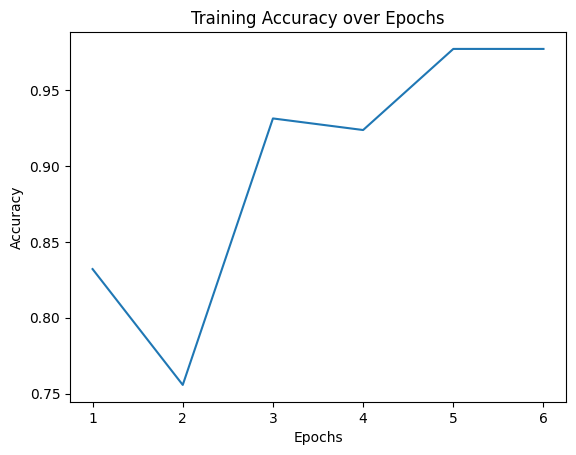

In [ ]:
# Train Model
from typing import List

def pad_collate_fn(batch: List[torch.Tensor]):
    input_ids, attention_mask, labels = zip(*batch)
    input_ids = torch.nn.utils.rnn.pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    attention_mask = torch.nn.utils.rnn.pad_sequence(attention_mask, batch_first=True, padding_value=0)
    labels = torch.tensor(labels, dtype=torch.long)

    return input_ids, attention_mask, labels

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn)


train_accuracies = []

for epoch in range(epochs):
    model.train()
    correct_preds = 0
    total_preds = 0

    for batch in train_dataloader:
        input_ids, attention_mask, labels = [elem.to(device) for elem in batch]
        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(logits, 1)
        correct_preds += (preds == labels).sum().item()
        total_preds += len(labels)

    train_accuracy = correct_preds / total_preds
    train_accuracies.append(train_accuracy)
    print(f"Epoch {epoch + 1}/{epochs} - Train Accuracy: {train_accuracy}")

plt.plot(range(1, epochs + 1), train_accuracies)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy over Epochs")
plt.show()


In [ ]:
# Evaluate the model on the test set after each epoch
model.eval()
epoch_predictions = []
epoch_ground_truth = []
with torch.no_grad():
  for batch in test_dataloader:
      input_ids, attention_mask, labels = [elem.to(device) for elem in batch]
      outputs = model(input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      _, preds = torch.max(logits, 1)
      epoch_predictions.extend(preds.cpu().numpy().tolist())
      epoch_ground_truth.extend(labels.cpu().numpy().tolist())
    
# Calculate and store the accuracy for this epoch
epoch_accuracy = accuracy_score(epoch_ground_truth, epoch_predictions)
epoch_accuracies.append(epoch_accuracy)
print(f"Epoch {epoch+1} Accuracy Score: {epoch_accuracy}"


Epoch 6 Accuracy Score: 0.543859649122807


## SVM

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix

# Preprocess the data as needed
X = data['Headline'].values
y = data['Label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize the data using TF-IDF
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train an SVM classifier with cross-validation
clf = svm.SVC(kernel='linear')
scores = cross_val_score(clf, X_train_tfidf, y_train, cv=5)

# Print the cross-validation scores
print('Cross-validation scores:', scores)
print('Mean accuracy:', scores.mean())

# Train the SVM classifier on the entire training set
clf.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test_tfidf)

# Evaluate the performance of the classifier
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

print("Accuracy:", accuracy_score(y_test, y_pred))



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: [0.53333333 0.5        0.53333333 0.46666667 0.5       ]
Mean accuracy: 0.5066666666666666
[[16  5]
 [12  5]]
              precision    recall  f1-score   support

           0       0.57      0.76      0.65        21
           2       0.50      0.29      0.37        17

    accuracy                           0.55        38
   macro avg       0.54      0.53      0.51        38
weighted avg       0.54      0.55      0.53        38

Accuracy: 0.5526315789473685
